# Coding Assignment 3

CS 598 Practical Statistical Learning

2023-10-09

UIUC Fall 2023

**Authors**
* Ryan Fogle
    - rsfogle2@illinois.edu
    - UIN: 652628818
* Sean Enright
    - seanre2@illinois.edu
    - UIN: 661791377

**Contributions**

TODO

## Part I

Here we implement LOO-CV and GCV to select the optimal span for LOESS.

In [1]:
# General imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Part 1 imports
from csaps import csaps
from skmisc.loess import loess

In [3]:
# Manual calculation of smoothing matrix
def smooth(x, y, fx, lam, axis=-1):
    """Fits a cubic spline to a given set of points, parameterized by lambda.

    Args:
        x (np.ndarray): Observations vector
        y (np.ndarray): Response vector
        fx (np.ndarray): Data sites for output smoothed data
        lam (float): Smoothing parameter (lambda)
        axis (np.ndarray): Axis along which y data varies

    Returns:
        (np.ndarray): Smoothed y data
    """
    p = 1 / (lam + 1) # CSAPS parameterizes by p, rather than R's lambda
    return csaps(x, y, fx, smooth=p, axis=axis)

def S_lam(x, lam):
    """Calculate the smoothing spline matrix for a vector observations and lambda value.

    Args:
        x (np.ndarray): Vector of observations
        lam (float): Smoothing parameter

    Returns:
        (np.ndarray): n x n smoothing matrix
    """
    n = len(x)
    Y = np.identity(n)
    A = smooth(x, Y, x, lam, axis=0)
    return (A + A.T) / 2

def lo_lev(x, sp):
    # Calculate diagonal entries of S, the smoothing matrix
    pass

In [4]:
def onestep_cv(x, y, sp):
    # 1) Fit a LOESS model y - x with span and extract the
    #    corresponding residual vector
    loess_fit = loess(x, y, span=sp)
    y_hat = loess_fit.predict(x).values
    # 2) Call lo_lev to obtain the diagonal entries of S
    s_ii = loess_fit.outputs.diagonal
    #s_ii = lo_lev(x, sp)
    # 3) Compute LOO-CV and GCV
    # LOOCV
    loocv = np.mean(np.power((y - y_hat) / (1 - s_ii), 2))
    # GCV
    m = np.mean(s_ii)
    gcv = np.mean(np.power((y - y_hat) / (1 - m), 2))
    return loocv, gcv

def find_cv_vals(x, y, span):
    m = len(span)
    cv = np.zeros(m)
    gcv = np.zeros(m)

    for i in range(m):
        cv_i, gcv_i = onestep_cv(x, y, span[i])
        cv[i] = cv_i
        gcv[i] = gcv_i
    return cv, gcv

Determining span values that produce the lowest LOOCV and GCV error.

In [5]:
# https://liangfgithub.github.io/Data/Coding3_Data.csv
data_part1 = pd.read_csv("Coding3_Data.csv")
span_vec = np.linspace(0.2, 0.9, 15)

# Find optimal span by LOOCV and GCV
loo, gcv = find_cv_vals(data_part1["x"], data_part1["y"], span_vec)

# Display table of CV results
print("Span    LOOCV   GCV")
for s, l, g in zip(span_vec, loo, gcv):
    print(f"{s:.2f}\t{l:.3f}\t{g:.3f}")

Span    LOOCV   GCV
0.20	12.416	2.110
0.25	2.241	1.489
0.30	1.503	1.190
0.35	1.259	1.174
0.40	1.190	1.103
0.45	1.157	1.063
0.50	1.124	1.040
0.55	1.180	1.119
0.60	1.179	1.119
0.65	1.251	1.181
0.70	1.554	1.519
0.75	1.636	1.627
0.80	1.765	1.745
0.85	1.976	1.926
0.90	2.035	1.980


The span optimization results are presented in the chart below.

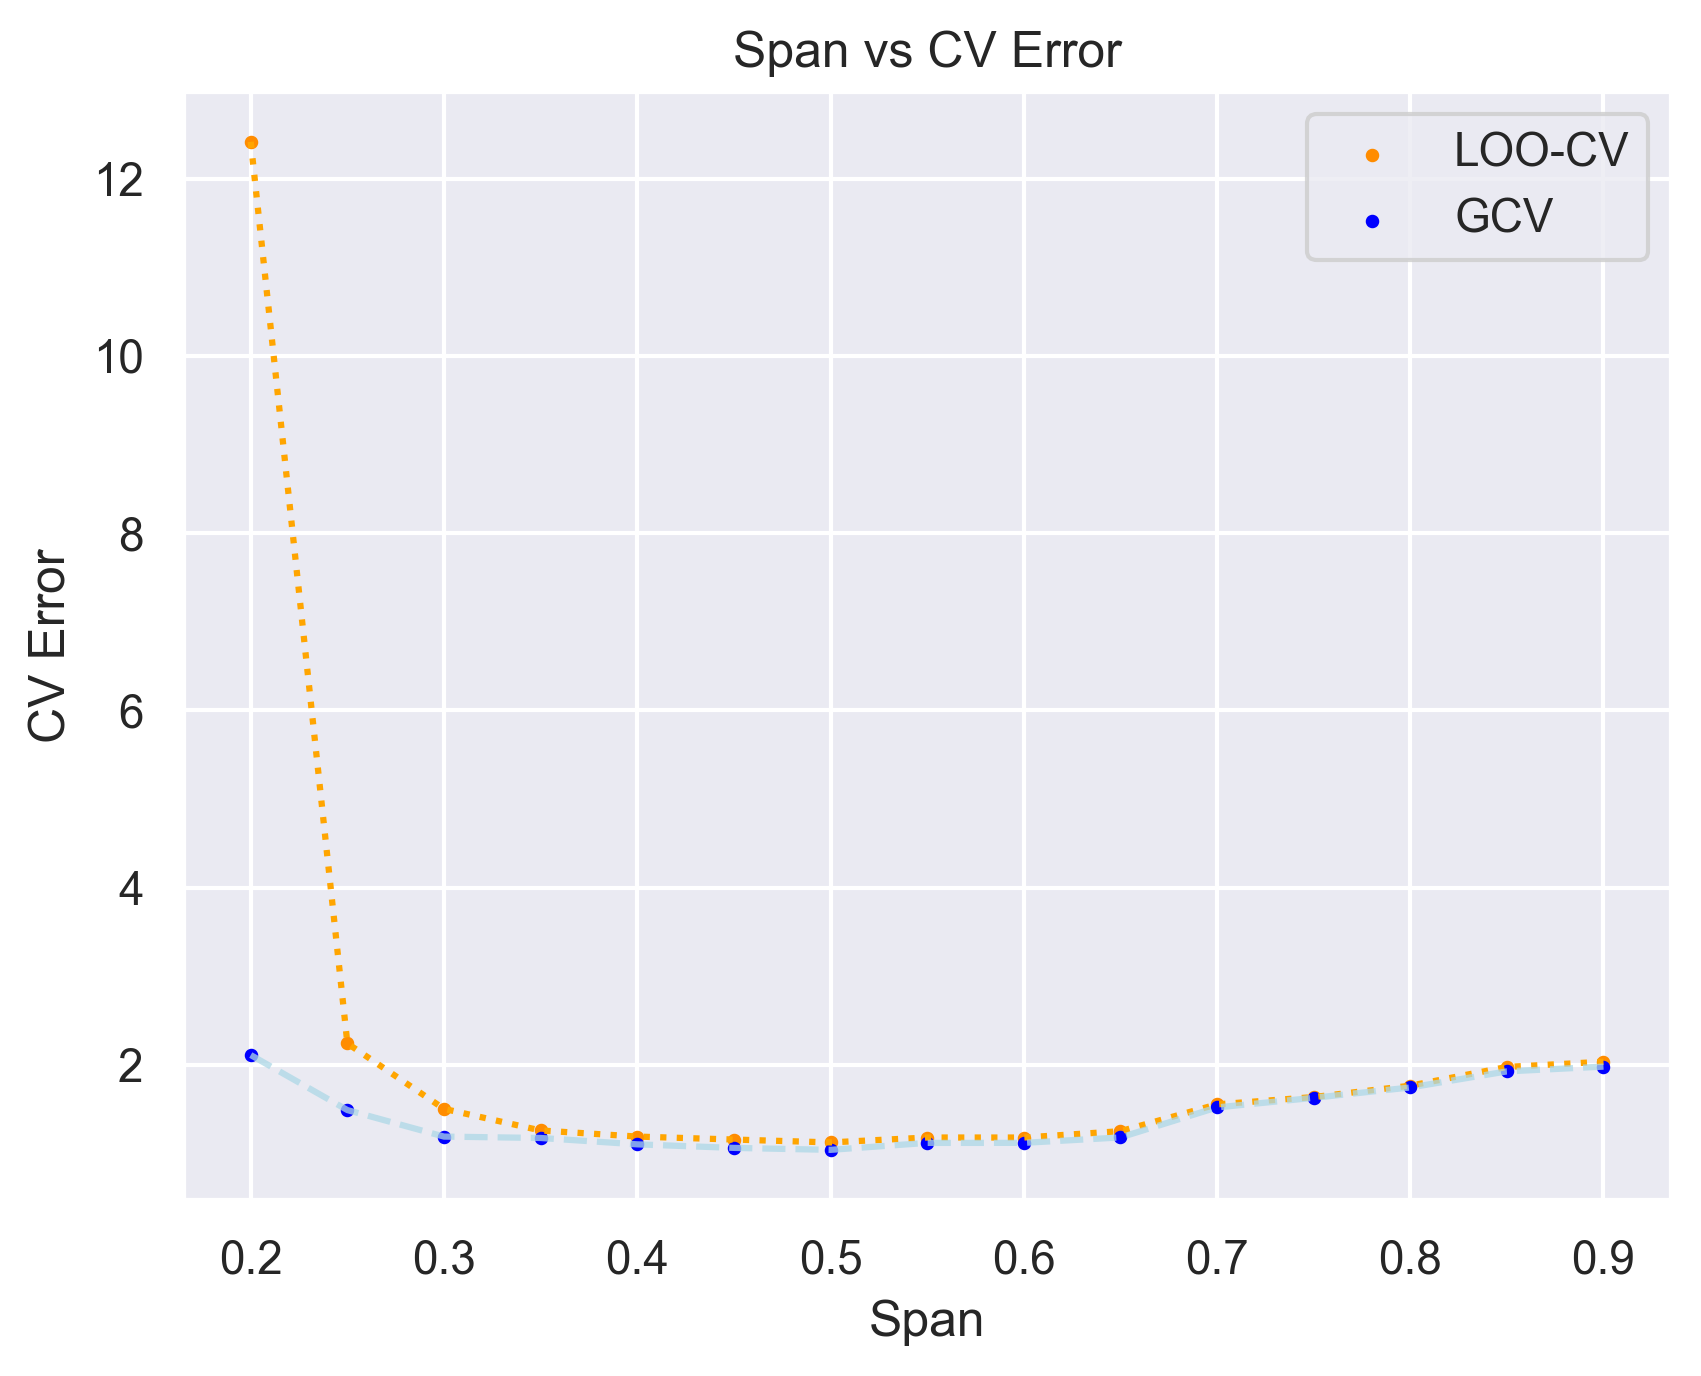

In [6]:
sns.set()
mpl.rcParams['figure.dpi'] = 300
plt.scatter(span_vec, loo, color="darkorange", s=5, label="LOO-CV")
plt.plot(span_vec, loo, color="orange", alpha=1, linestyle="dotted")
plt.scatter(span_vec, gcv, color="blue", s=5, label="GCV")
plt.plot(span_vec, gcv, color="lightblue", alpha=0.75, linestyle="--")
plt.xlabel("Span")
plt.ylabel("CV Error")
plt.title("Span vs CV Error")
plt.legend()

For this dataset and choice of span values, the best span value selected by LOOCV and GCV is the same.

In [7]:
# Select lowest span value
span_loocv = span_vec[np.argmin(loo)]
span_gcv = span_vec[np.argmin(gcv)]

print(f"Span by LOO-CV: {span_loocv}")
print(f"   Span by GCV: {span_gcv}")

Span by LOO-CV: 0.5
   Span by GCV: 0.5


The true curve is defined below.

In [8]:
def f(x):
    return np.sin(12 * (x + 0.2)) / (x + 0.2)

fx = np.linspace(min(data_part1["x"]), max(data_part1["x"]), 1001)
fy = f(fx)

Finally, we compare the LOESS curve with LOO-CV and GCV optimized span to the true curve.

Text(0, 0.5, 'Y')

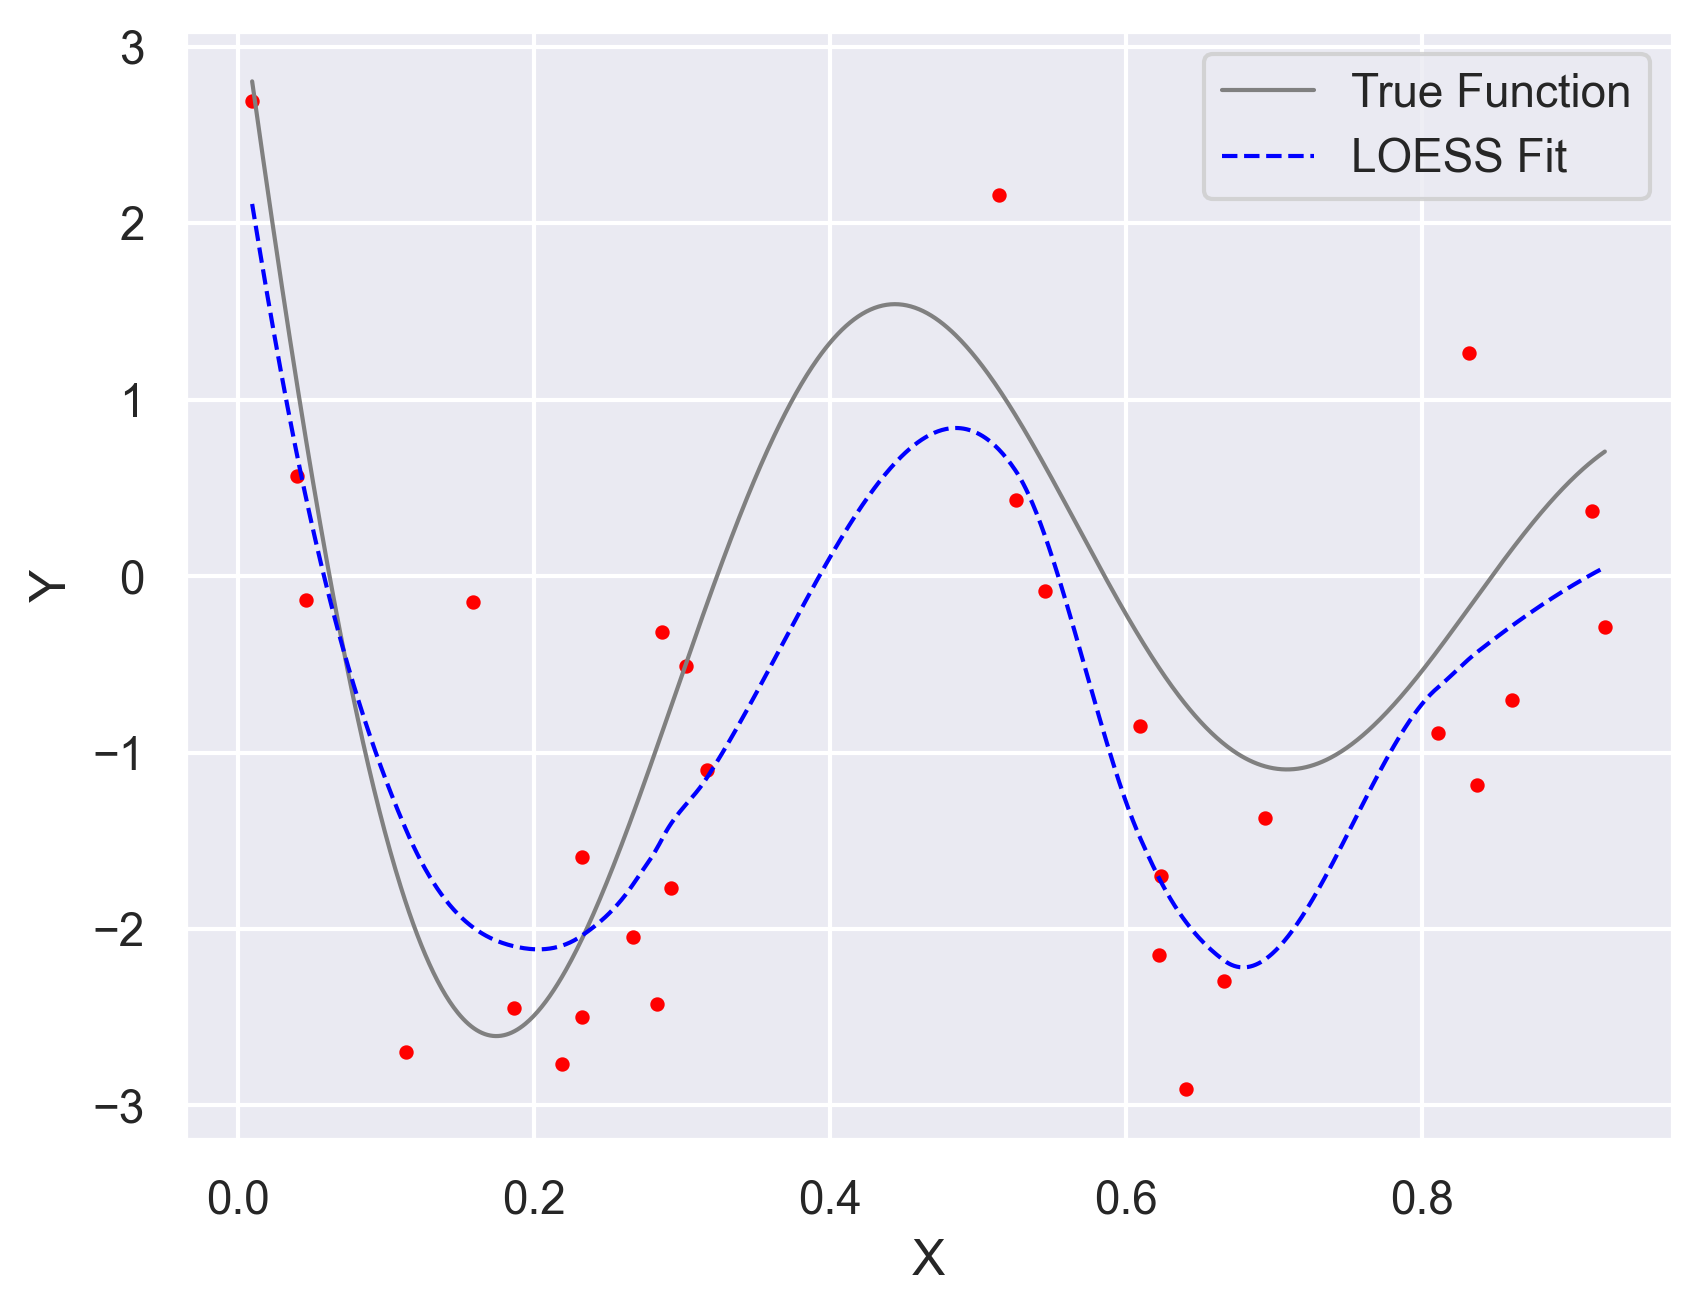

In [9]:
y_loess = loess(data_part1["x"], data_part1["y"], span=span_loocv).predict(fx).values

sns.set()
mpl.rcParams['figure.dpi'] = 300
plt.scatter(data_part1["x"], data_part1["y"], color="red", s=6)
plt.plot(fx, fy, color="gray", linewidth=1, label="True Function")
plt.plot(fx, y_loess, color="blue", linewidth=1, linestyle="--", label="LOESS Fit")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")

## Part II



The following imports are specific to Part II

In [10]:
from numpy.linalg import inv
from scipy.interpolate import splev
from sklearn.cluster import KMeans

In this part we use the Sales_Transactions_Dataset_Weekly dataset from the UCI Machine Learning Repository. After reading the dataset file, we select the time series data and center the time series data by its row means, resulting in $\textbf{X}_{811 \times 52}$.

In [11]:
# https://archive.ics.uci.edu/dataset/396/sales+transactions+dataset+weekly
X = pd.read_csv("Sales_Transactions_Dataset_Weekly.csv",
                         index_col=0, usecols=range(53))
# Normalize each time series, i.e., normalize each row by its mean
X = X.sub(X.mean(axis=1), axis=0).to_numpy()
X.shape

(811, 52)

The time series features are simply a vector of indeces corresponding to the weeks of the year.

In [12]:
t = np.arange(start=1, stop=53)
t.shape

(52,)

Here, a Python implementation of R's `splines::ns` is provided. It will be used to generate a natural cubic spline basis function matrix. It was copied from [the course website](https://liangfgithub.github.io/Python_W5_RegressionSpline.html).

In [13]:
# ref: https://liangfgithub.github.io/Python_W5_RegressionSpline.html
# converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3
    
    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0
            
        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
                    
            basis[oright, :] = xr @ tt
        
        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis

We use `ns` to generate the basis function matrix $\textbf{F}_{52 \times 9}$ and remove the intercept by centering its columns by their means.

In [14]:
F_mat = ns(t, df=9, include_intercept=False)
F_mat = F_mat - F_mat.mean(axis=0)[np.newaxis, :]
F_mat.shape

(52, 9)

With $\textbf{F}$ and $\textbf{X}$, we can calculate a matrix of spline coefficients for every obbservation, $\textbf{B}_{811 \times 9}$. This is found by the following formula, which is implemented below.

$$
\textbf{B}^{\top} = (\textbf{F}^{\top} \ \textbf{F})^{-1} \ \textbf{F}^{\top} \textbf{X}^{\top}
$$

In [15]:
B = inv(F_mat.T @ F_mat) @ F_mat.T @ X.T
B = B.T
B.shape

(811, 9)

### Clustering using Matrix $\textbf{B}$

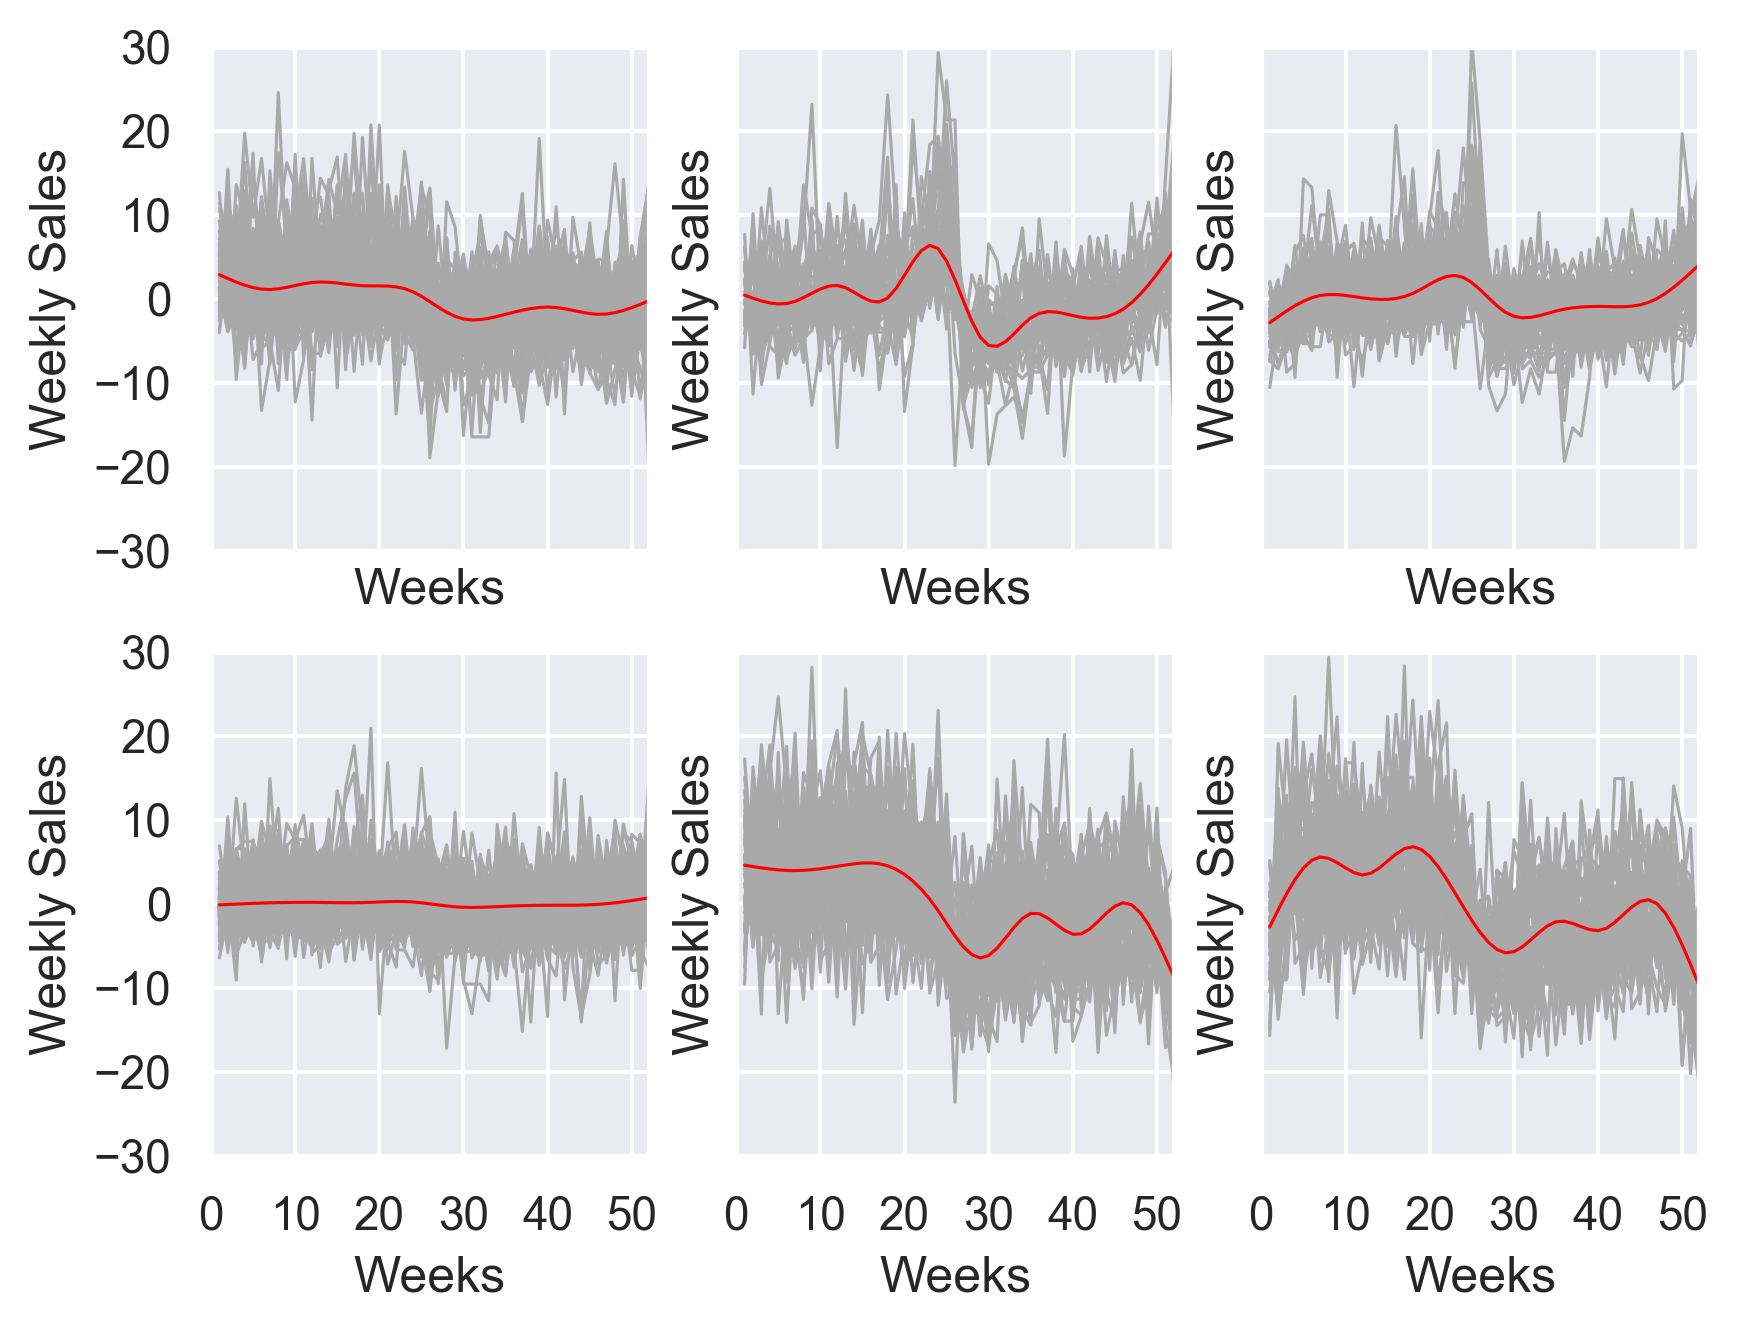

In [16]:
n_clusters = 6
n_row = 2
n_col = 3

km_B = KMeans(n_clusters=n_clusters, n_init=10).fit(B)
centers_B = F_mat @ km_B.cluster_centers_.T

fig, axs = plt.subplots(nrows=2, ncols=3, dpi=300,
                        sharex="all", sharey="all")
for i in range(n_row):
    for j in range(n_col):
        series = X[km_B.labels_ == i * n_col + j, :]
        for k in range(series.shape[0]):
            axs[i, j].plot(t, series[k], color="darkgrey", linewidth=0.75)
        axs[i, j].plot(t, centers_B[:, i * n_col + j], color="red", linewidth=0.75)
        axs[i, j].set_xlim([1, 52])
        axs[i, j].set_ylim([-30, 30])
        axs[i, j].set_xticks(range(0, 52, 10))
        axs[i, j].set_yticks(np.linspace(-30, 30, 7))
        axs[i, j].set_xlabel("Weeks")
        axs[i, j].set_ylabel("Weekly Sales")

### Clustering using Matrix $\textbf{B}$

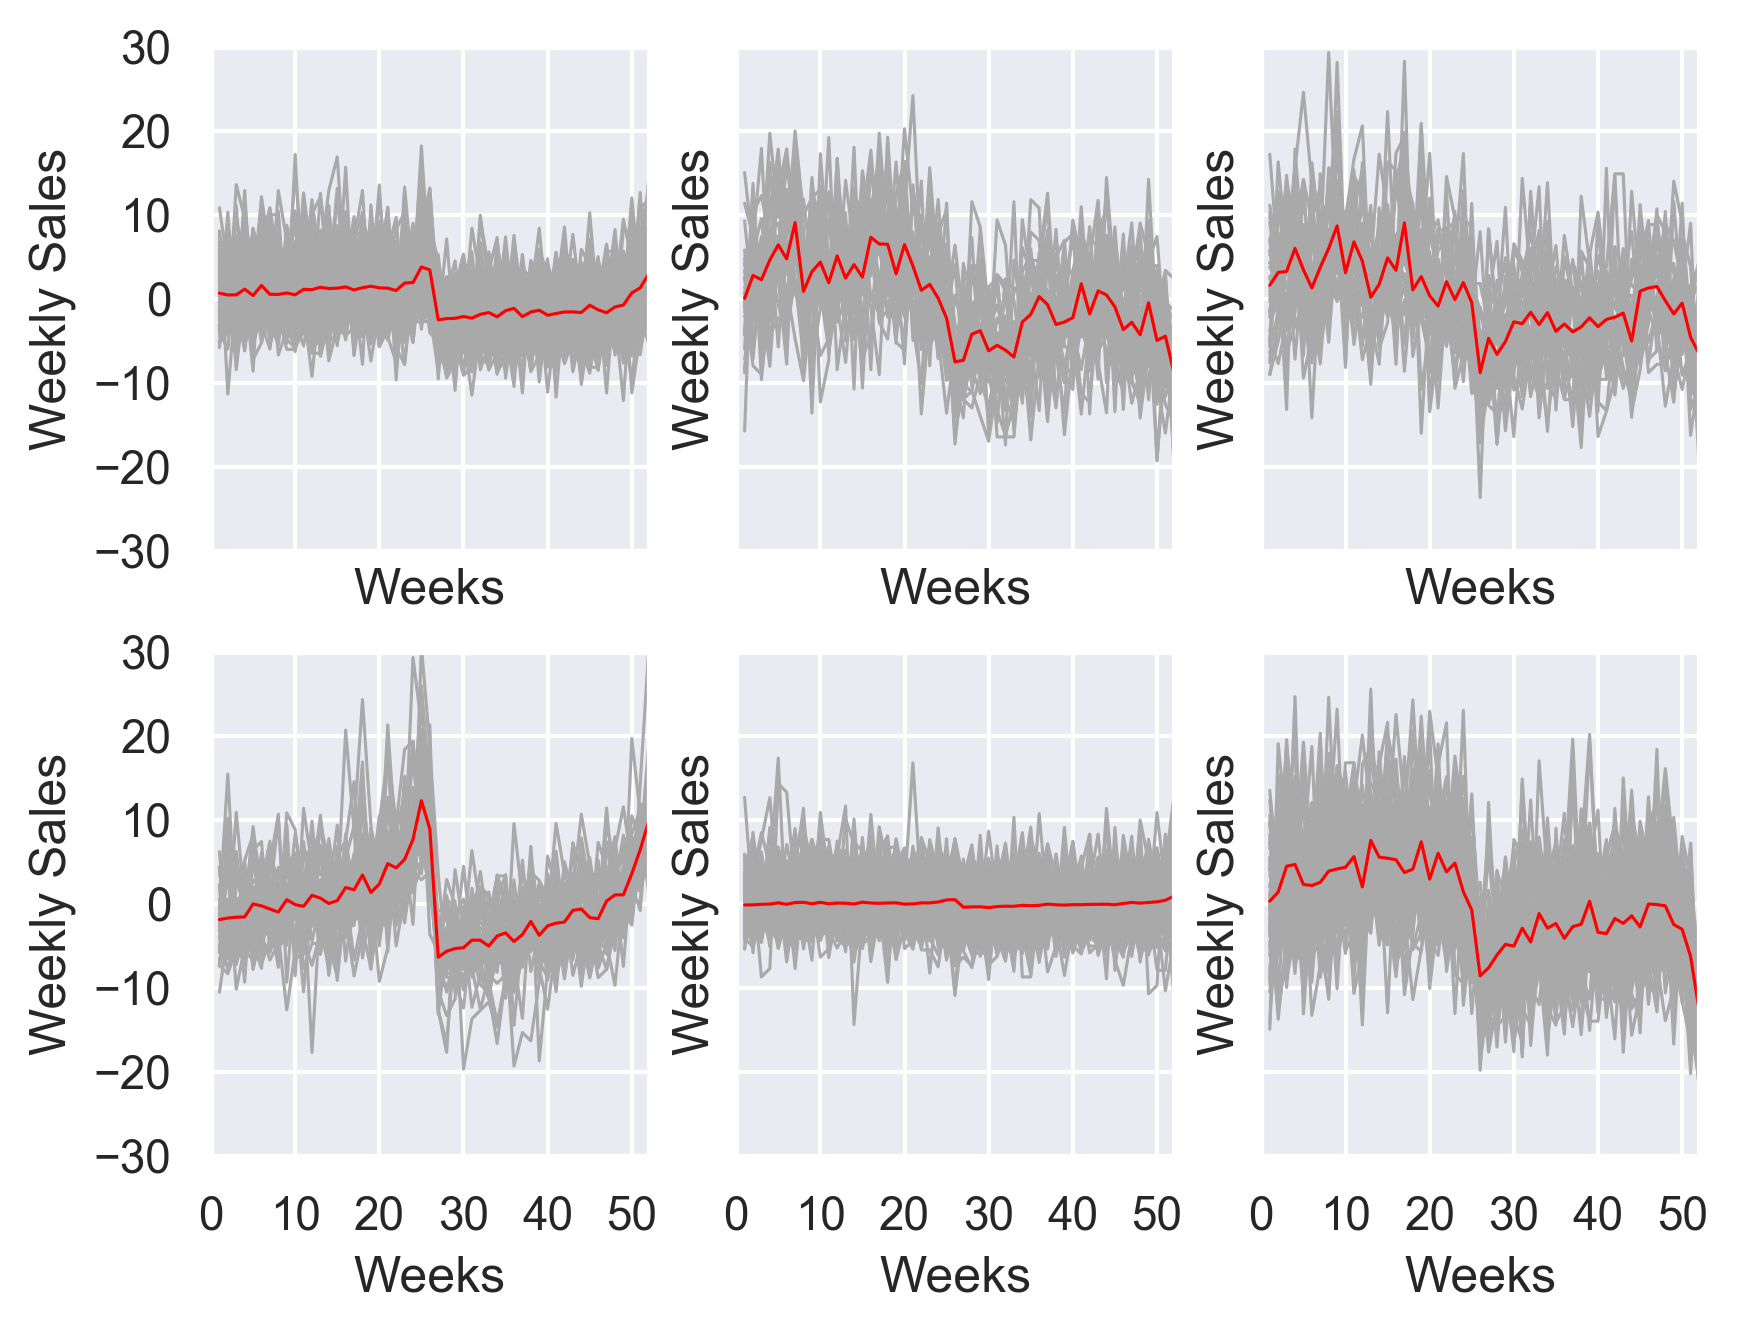

In [17]:
km_X = KMeans(n_clusters=n_clusters, n_init=10).fit(X)
centers_X = km_X.cluster_centers_.T

fig, axs = plt.subplots(nrows=2, ncols=3, dpi=300,
                        sharex="all", sharey="all")
for i in range(n_row):
    for j in range(n_col):
        series = X[km_X.labels_ == i * n_col + j, :]
        for k in range(series.shape[0]):
            axs[i, j].plot(t, series[k], color="darkgrey", linewidth=0.75)
        axs[i, j].plot(t, centers_X[:, i * n_col + j], color="red", linewidth=0.75)
        axs[i, j].set_xlim([1, 52])
        axs[i, j].set_ylim([-30, 30])
        axs[i, j].set_xticks(range(0, 52, 10))
        axs[i, j].set_yticks(np.linspace(-30, 30, 7))
        axs[i, j].set_xlabel("Weeks")
        axs[i, j].set_ylabel("Weekly Sales")